# 궁극의 코드 

In [10]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc

def set_korean_font():
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    os_name = platform.system()

    if os_name == 'Linux':
        # 우분투용 폰트 설정
        path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'
        font_name = font_manager.FontProperties(fname=path, size=12).get_name()
        rc('font', family=font_name)
        print("Linux (Ubuntu) 환경에서 한글 폰트 설정 완료!")
    elif os_name == 'Darwin':
        # macOS용 폰트 설정
        rc('font', family='AppleGothic')
        print("macOS 환경에서 한글 폰트 설정 완료!")
    elif os_name == 'Windows':
        # 윈도우용 폰트 설정
        path = "c:/Windows/Fonts/malgun.ttf"
        font_name = font_manager.FontProperties(fname=path).get_name()
        rc('font', family=font_name)
        print("Windows 환경에서 한글 폰트 설정 완료!")
    else:
        print(f"{os_name}는 지원되지 않는 운영체제입니다.")

# 한글 폰트 설정 실행
set_korean_font()

macOS 환경에서 한글 폰트 설정 완료!


데이터셋의 첫 5행:
            ID      대출금액        대출기간       근로기간    주택소유상태       연간소득  \
0  TRAIN_00000  12480000   36 months    6 years      RENT   72000000   
1  TRAIN_00001  14400000   60 months  10+ years  MORTGAGE  130800000   
2  TRAIN_00002  12000000   36 months    5 years  MORTGAGE   96000000   
3  TRAIN_00003  14400000   36 months    8 years  MORTGAGE  132000000   
4  TRAIN_00004  18000000   60 months    Unknown      RENT   71736000   

   부채_대비_소득_비율  총계좌수   대출목적  최근_2년간_연체_횟수   총상환원금     총상환이자  총연체금액  연체계좌수 대출등급  
0        18.90    15  부채 통합             0       0       0.0    0.0    0.0    C  
1        22.33    21  주택 개선             0  373572  234060.0    0.0    0.0    B  
2         8.60    14  부채 통합             0  928644  151944.0    0.0    0.0    A  
3        15.09    15  부채 통합             0  325824  153108.0    0.0    0.0    C  
4        25.39    19  주요 구매             0  228540  148956.0    0.0    0.0    B  

데이터셋의 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294

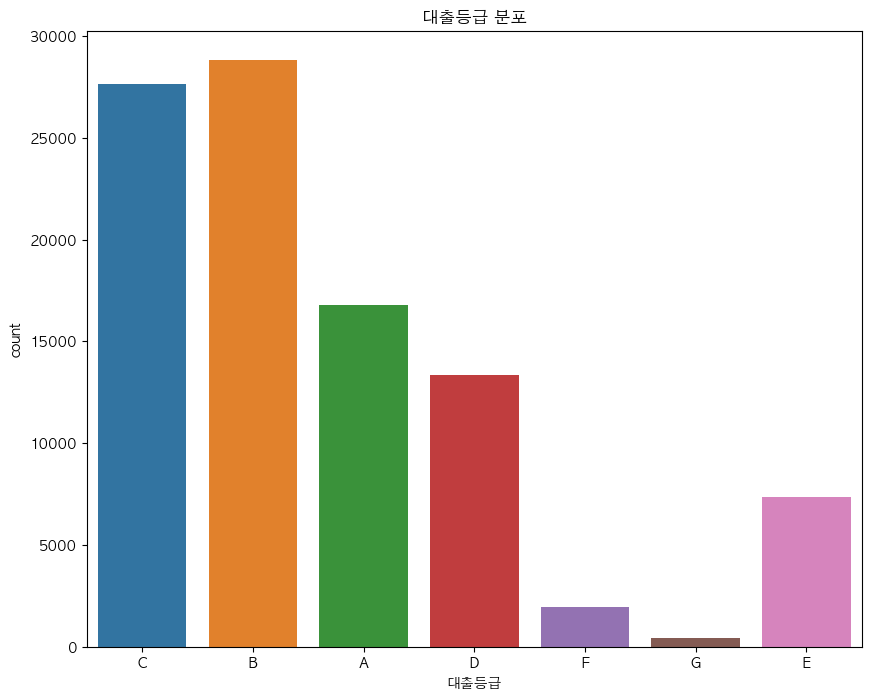

In [11]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기
file_path = 'train.csv'
data = pd.read_csv(file_path)

# 데이터 탐색 (Exploratory Data Analysis, EDA)
print("데이터셋의 첫 5행:")
print(data.head())
print("\n데이터셋의 기본 정보:")
print(data.info())

# 결측치 확인
print("\n결측치 확인:")
print(data.isnull().sum())

# 데이터 분포 시각화
plt.figure(figsize=(10, 8))
sns.countplot(x='대출등급', data=data)
plt.title('대출등급 분포')
plt.show()


# 근로기간 데이터를 수치형으로 변환하는 함수
def convert_employment_length_to_numeric(value):
    if value == 'Unknown':
        return 0
    else:
        # 숫자만 추출
        numeric_value = re.findall('\d+', value)
        if numeric_value:
            return int(numeric_value[0])
        else:
            return 0

# 근로기간 데이터 변환
data['근로기간'] = data['근로기간'].apply(convert_employment_length_to_numeric)
data['근로기간'] = data['근로기간'].astype(int)


In [12]:
# 대출기간 전처리
data['대출기간'] = data['대출기간'].str.strip()
data['대출기간'] = data['대출기간'].str.split(' ', expand=True)[0]
data['대출기간'] = data['대출기간'].astype(int)

In [13]:
# One-Hot Encoding을 사용하여 범주형 변수 인코딩
categorical_features = ['주택소유상태', '대출목적']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# 타겟 변수 ('대출등급') 인코딩
data['대출등급'] = LabelEncoder().fit_transform(data['대출등급'])

# 훈련 데이터와 테스트 데이터 분할
X = data.drop(['ID', '대출등급'], axis=1)
y = data['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/opt/homebrew/Caskroom/miniforge/base/envs/dask_1/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


정확도: 0.8642712498052858
혼동 행렬:
[[2923  322   24    1    1    0    0]
 [ 222 5196  370   15    4    0    0]
 [  35  364 4888  188   16    3    0]
 [  10   67  299 2226  132    6    2]
 [   1   16   54  258 1081   34    4]
 [   0    4   21   14   76  291   11]
 [   0    0    3    2    7   28   40]]
정밀도: 0.828559958277564
재현율: 0.7763279155473627
F1 점수: 0.7991617982483827


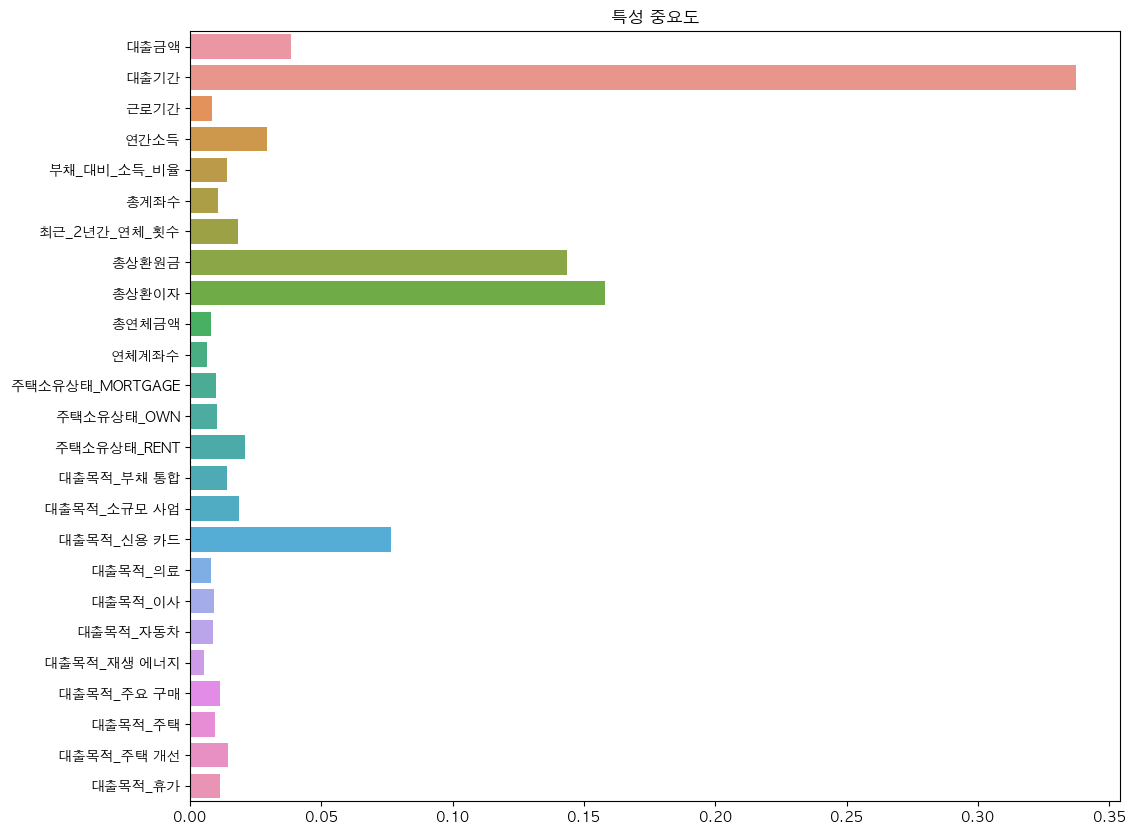

In [14]:
# 모델링 (XGBoost)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"정확도: {accuracy}")
print(f"혼동 행렬:\n{conf_matrix}")
print(f"정밀도: {precision}")
print(f"재현율: {recall}")
print(f"F1 점수: {f1}")

# 특성 중요도 시각화
feature_importances = model.feature_importances_
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances, y=X.columns)
plt.title('특성 중요도')
plt.show()


# 하나의 코드 

### **분류 모델의 예:**

- **로지스틱 회귀(Logistic Regression):**
    - 이진 분류 문제에 주로 사용되며, 입력 데이터가 특정 클래스에 속할 확률을 추정.
- **결정 트리(Decision Trees):**
    -  데이터를 분류하기 위한 질문을 연속적으로 물어보며, 각 질문의 답에 따라 데이터를 분리합니다. 
    - 결정 트리는 이진 트리 구조를 가지며, 이진 분류와 다중 분류 모두에 사용될 수 있습니다.
- **랜덤 포레스트(Random Forest):** 
    - 결정 트리의 앙상블 모델로, 여러 개의 결정 트리를 학습시키고 
    - 각 트리의 예측을 결합하여 최종 예측을 수행합니다. 
    - 과적합을 방지하고 일반화 성능을 향상시키는 데 효과적입니다.
- **서포트 벡터 머신(Support Vector Machines, SVM):** 
    - 데이터를 벡터 공간에 매핑하고, 클래스를 분리하는 최적의 경계를 찾아내는 모델입니다. 
    - 이진 분류 문제에 주로 사용되지만, 다중 분류에도 적용할 수 있습니다.
- **XGBoost, LightGBM, CatBoost 등의 그래디언트 부스팅 모델:** 
    - 각각이 결정 트리 기반의 앙상블 학습 방법을 사용하며, 
    - 약한 분류기를 순차적으로 학습시키면서 잘못 분류된 데이터에 더 많은 가중치를 부여하여 성능을 향상시킵니다.

# XGBOOST 

![nn](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/images/xgboost_illustration.png)

XGBoost(Extreme Gradient Boosting)는 그래디언트 부스팅 알고리즘을 구현한 라이브러리로, 
- 높은 성능과 속도 
- 여러 가지 최적화와 정규화 기법을 통해 과적합을 방지함

데이터셋의 첫 5행:
            ID      대출금액        대출기간       근로기간    주택소유상태       연간소득  \
0  TRAIN_00000  12480000   36 months    6 years      RENT   72000000   
1  TRAIN_00001  14400000   60 months  10+ years  MORTGAGE  130800000   
2  TRAIN_00002  12000000   36 months    5 years  MORTGAGE   96000000   
3  TRAIN_00003  14400000   36 months    8 years  MORTGAGE  132000000   
4  TRAIN_00004  18000000   60 months    Unknown      RENT   71736000   

   부채_대비_소득_비율  총계좌수   대출목적  최근_2년간_연체_횟수   총상환원금     총상환이자  총연체금액  연체계좌수 대출등급  
0        18.90    15  부채 통합             0       0       0.0    0.0    0.0    C  
1        22.33    21  주택 개선             0  373572  234060.0    0.0    0.0    B  
2         8.60    14  부채 통합             0  928644  151944.0    0.0    0.0    A  
3        15.09    15  부채 통합             0  325824  153108.0    0.0    0.0    C  
4        25.39    19  주요 구매             0  228540  148956.0    0.0    0.0    B  

데이터셋의 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294

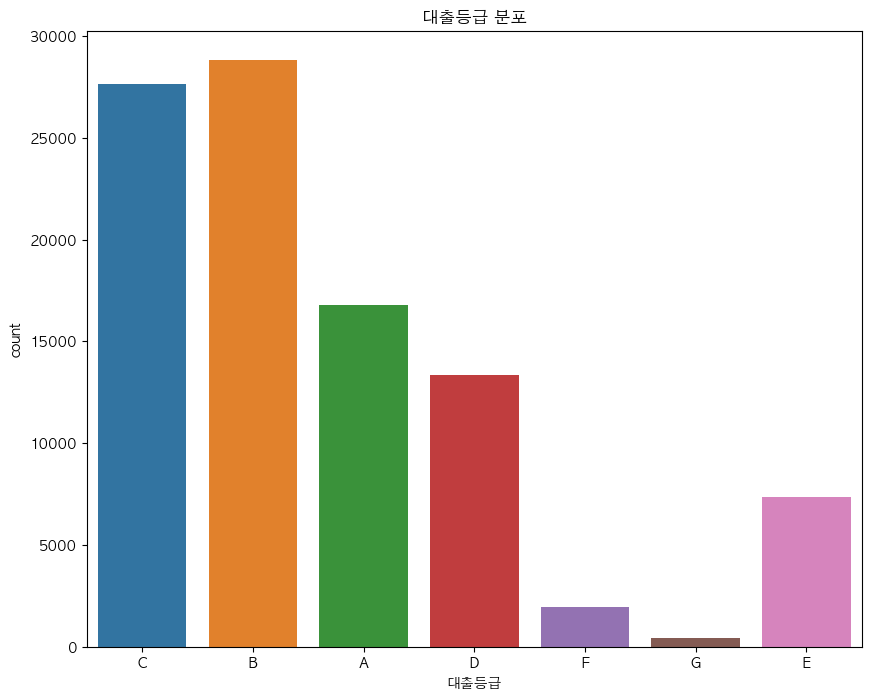

/opt/homebrew/Caskroom/miniforge/base/envs/dask_1/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


정확도: 0.8642712498052858
혼동 행렬:
[[2923  322   24    1    1    0    0]
 [ 222 5196  370   15    4    0    0]
 [  35  364 4888  188   16    3    0]
 [  10   67  299 2226  132    6    2]
 [   1   16   54  258 1081   34    4]
 [   0    4   21   14   76  291   11]
 [   0    0    3    2    7   28   40]]
정밀도: 0.828559958277564
재현율: 0.7763279155473627
F1 점수: 0.7991617982483827


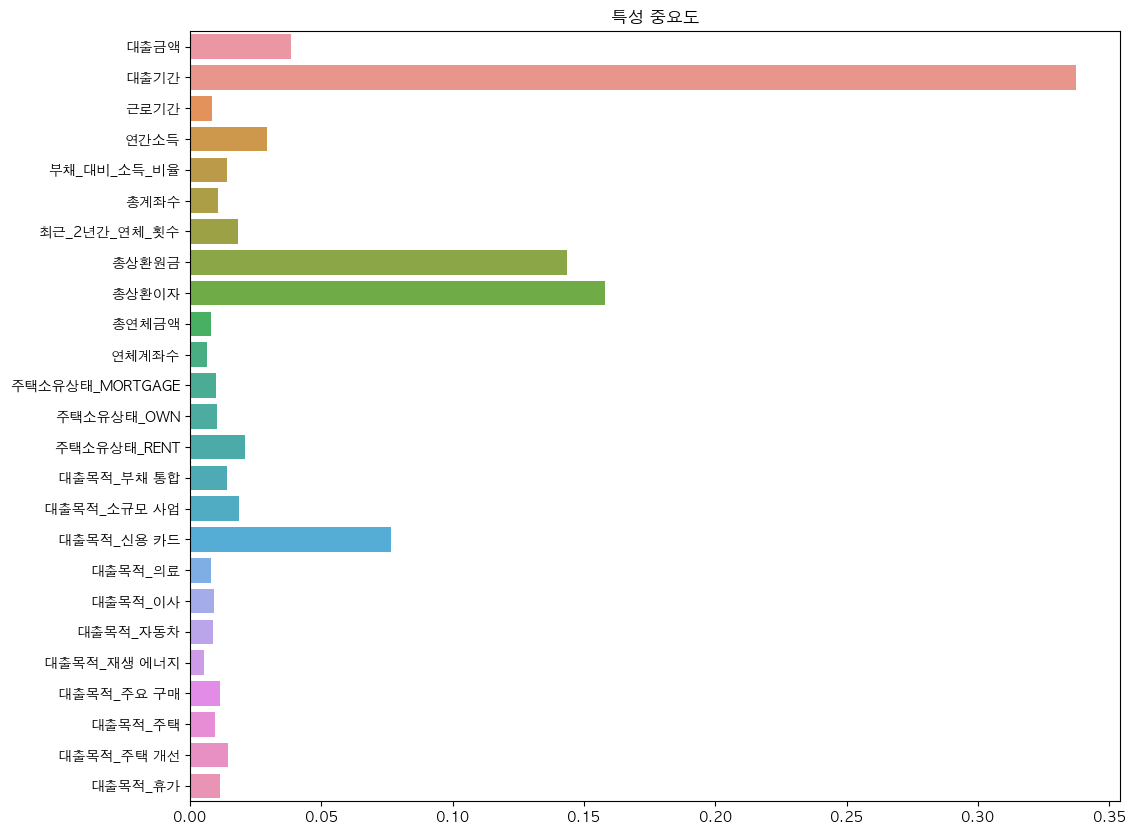

'\n값의 범위: 각 피처의 중요도는 0과 1 사이의 값을 가집니다.\n값이 높을수록 해당 피처가 모델의 결정에 더 큰 영향을 미친다는 것을 의미.\n\n해석: 모델이 피처를 얼마나 "중요하게" 사용했는지를 나타내지만, \n피처의 영향 방향(양의 관계인지 음의 관계인지)이나 복잡한 관계(비선형성 등)를 설명하지는 않습니다.\n사용 모델: feature_importances_는 결정 트리(Decision Tree),\n 랜덤 포레스트(Random Forest), 그리고 XGBoost와 같은 그래디언트 부스팅 모델 등, 트리 기반 모델에서 제공됩니다.\n사용\n'

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder

# 데이터 불러오기
file_path = 'train.csv'
data = pd.read_csv(file_path)

# 데이터 탐색 (Exploratory Data Analysis, EDA)
print("데이터셋의 첫 5행:")
print(data.head())
print("\n데이터셋의 기본 정보:")
print(data.info())

# 결측치 확인
print("\n결측치 확인:")
print(data.isnull().sum())

# 데이터 분포 시각화
plt.figure(figsize=(10, 8))
sns.countplot(x='대출등급', data=data)
plt.title('대출등급 분포')
plt.show()


# 근로기간 데이터를 수치형으로 변환하는 함수
def convert_employment_length_to_numeric(value):
    if value == 'Unknown':
        return 0
    else:
        # 숫자만 추출
        numeric_value = re.findall('\d+', value)
        if numeric_value:
            return int(numeric_value[0])
        else:
            return 0

# 근로기간 데이터 변환
data['근로기간'] = data['근로기간'].apply(convert_employment_length_to_numeric)
data['근로기간'] = data['근로기간'].astype(int)

# 대출기간 전처리
data['대출기간'] = data['대출기간'].str.strip()
data['대출기간'] = data['대출기간'].str.split(' ', expand=True)[0]
data['대출기간'] = data['대출기간'].astype(int)

# One-Hot Encoding을 사용하여 범주형 변수 인코딩
"""
원-핫 인코딩(One-Hot Encoding)
원-핫 인코딩은 범주형 변수를 0과 1로 이루어진 벡터로 변환합니다.
각 범주는 하나의 원소만 1이고 나머지는 0인 벡터로 표현됩니다.
이 방법은 모델이 범주형 변수의 순서를 고려하지 않도록 하며, 
선형 모델과 같은 알고리즘에서 주로 사용됩니다.
"""

categorical_features = ['주택소유상태', '대출목적']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# 타겟 변수 ('대출등급') 인코딩
"""
라벨 인코딩(Label Encoding)
라벨 인코딩은 범주형 변수의 문자열을 숫자로 변환하는 과정
각 범주(카테고리)에 고유의 정수를 할당합니다.
예를 들어, '빨강', '노랑', '파랑' 세 가지 색상이 있다면 
라벨 인코딩은 이를 0, 1, 2와 같이 숫자로 변환할 수 있습니다. 
라벨 인코딩은 트리 기반 알고리즘에서 유용하지만, 
숫자의 크고 작음이 모델에 영향을 줄 수 있으므로 선형 모델에서는 주의해서 사용해야 합니다.
"""
data['대출등급'] = LabelEncoder().fit_transform(data['대출등급'])

# 훈련 데이터와 테스트 데이터 분할
X = data.drop(['ID', '대출등급'], axis=1)
y = data['대출등급']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델링 (XGBoost)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

"""
모델 평가 기준(Model Evaluation Metrics)
모델의 성능을 평가하기 위해 다양한 지표가 사용됩니다. 
분류 문제에서는 주로 정확도(Accuracy), 정밀도(Precision), 재현율(Recall), F1 점수(F1 Score) 등이 사용됩니다.

정확도(Accuracy): 전체 예측 중 올바르게 예측된 비율입니다.
정밀도(Precision): 양성으로 예측된 사례 중 실제 양성인 사례의 비율입니다.
재현율(Recall): 실제 양성인 사례 중 양성으로 올바르게 예측된 비율입니다.
F1 점수(F1 Score): 정밀도와 재현율의 조화 평균입니다. 불균형 데이터셋에서 유용하게 사용됩니다.
"""

print(f"정확도: {accuracy}")
print(f"혼동 행렬:\n{conf_matrix}")
print(f"정밀도: {precision}")
print(f"재현율: {recall}")
print(f"F1 점수: {f1}")

# 특성 중요도 시각화
feature_importances = model.feature_importances_
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances, y=X.columns)
plt.title('특성 중요도')
plt.show()

"""
값의 범위: 각 피처의 중요도는 0과 1 사이의 값을 가집니다.
값이 높을수록 해당 피처가 모델의 결정에 더 큰 영향을 미친다는 것을 의미.

해석: 모델이 피처를 얼마나 "중요하게" 사용했는지를 나타내지만, 
피처의 영향 방향(양의 관계인지 음의 관계인지)이나 복잡한 관계(비선형성 등)를 설명하지는 않습니다.
사용 모델: feature_importances_는 결정 트리(Decision Tree),
 랜덤 포레스트(Random Forest), 그리고 XGBoost와 같은 그래디언트 부스팅 모델 등, 트리 기반 모델에서 제공됩니다.
사용
"""

# Confusino Matrix
![confusion](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FmgyPF%2FbtqDkAkjNSL%2FMqUcOIIdnIyP6zK9J5jzF0%2Fimg.png)
- TP (True Positive): 양성으로 올바르게 분류된 경우
- TN (True Negative): 음성으로 올바르게 분류된 경우
- FP (False Positive): 음성인데 양성으로 잘못 분류된 경우 (1종 오류)
- FN (False Negative): 양성인데 음성으로 잘못 분류된 경우 (2종 오류)

- 정확도 (Accuracy) : 전체 샘플 중 올바르게 예측된 샘플의 비율
    - (TP + TN) / (TP + TN + FP + FN)
- 정밀도 (Precision): 양성으로 예측된 샘플 중 실제 양성인 샘플의 비율
    - (TP) / (TP + FP)
- 재현율 (Recall): 실제 양성 샘플 중 양성으로 올바르게 예측된 샘플의 비율
    - (TP) / (TP + FN)
- F1 점수 (F1 Score): 정밀도와 재현율의 조화 평균
    - 2 * (precision * recall) / (precision + recall)